# Lecture 7: Optimization Using Python - ORTools

In this lecture / tutorial, we will learn how to solve some simple optimization problems using Python. This involves a brief introduction to the various optimization libraries available, such as ```scipy.optimize```, ```ortools```, and ```cplex```. We will solve an example optimization problem using each library.

***

## Learning goals
- Obtain an overview of optimization problems that can be easily solved using Python.
- Know about some of the popular optimization libraries which have easy to use Python interfaces.
- Learn the syntax to solve some simple optimization problems using at least a couple of the libraries discussed in this tutorial.
- Test your understanding by solving a few of the practice problems in each section.

***
# Prerequisites for running this notebook

You should have Python 3.6 installed on your computer, with all necessary packages installed.

We recommend that you install Anaconda (Python 3.6 version) from the following links depending on your OS:
- For Windows: https://www.anaconda.com/download/#windows
- For macOS: https://www.anaconda.com/download/#macos
- For Linux: https://www.anaconda.com/download/#linux

**If you are not using Anaconda, it is your responsibility to make sure that Python and all necessary packages are correctly installed and configured to be able to run this notebook.**

***

Once Anaconda is installed, open a **Terminal** (if you are using macOS / Linux), or **Anaconda Prompt** (if you are using Windows), and then create a new Python environment called **cme193**, by running the following command:<br>
> ```conda create -n cme193 python=3.6```

Next, change to the newly created virtual environment by running the command:

On Windows
> ```activate cme193``` <br>

On macOS or Linux
> ```source activate cme193```

Next install all the necessary packages by running the following commands:

> ```conda install nb_conda``` <br>
> ```conda install -c anaconda scipy``` <br>
> ```conda install -c conda-forge matplotlib``` <br>
> ```conda install -c anaconda networkx``` <br>
> ```pip install ortools``` <br>

Now navigate to the directory containing this .ipynb file, from inside the terminal, and start jupyter notebook by typing the following command:
> ```jupyter notebook```

You should now be able to launch the .ipynb file from the browser. For more information on jupyter notebooks, read the <a href="https://jupyter-notebook.readthedocs.io/en/stable/notebook.html" style="text-decoration: none;">user documentation</a>.

***
# Introduction to OR-Tools

In this section we will learn how to solve some simple optimization problems using the ```OR-Tools``` package. ```OR-Tools``` is an open source software suite for optimization, available from Google. It is possible to configure ```OR-Tools``` to use commercial solvers like ```CPLEX``` or ```Gurobi```, or open-source solvers like ```SCIP``` or ```GLPK```, but this involves building ```OR-Tools``` from source, and we will not discuss this here as it is an advanced topic that is not suited for an introductory course on Python. Instead we will focus on using Google's ```GLOP``` and ```CP-SAT``` solver which is available upon following the installation instructions, as described above. More information on ```OR-Tools``` can be found at the <a href="https://developers.google.com/optimization/" style="text-decoration: none;">OR-Tools homepage</a>. The user guide can be found <a href="https://developers.google.com/optimization/introduction/overview" style="text-decoration: none;">here</a>, which contains extensive documentation and lots of examples.

**Note: Detailed documentation only exists for C++ interface. The documentation for the Python interface is mostly work in progress. But the examples provided by ```OR-Tools``` are good enough to do many sophisticated tasks at an introductory level!**

The main tools provided by ```OR-Tools```, that we need to be aware of are solvers for the following broad category of problems:
- ```Constraint Programming```: The specialized ```CP-SAT``` solver (or the old ```original CP solver```) has been designed specifically to solve these kind of problems. The current recommendation is to always use the ```CP-SAT``` solver whenever possible. We will mostly stick to this guideline in this tutorial, with a few possible exceptions.
- ```Linear and Mixed Integer Linear Programming```: These are the kind of problems that the specialized library ```GLOP``` is designed to solve. For solving Mixed Integer Linear Programming (MILP) problems, the default installer uses the <a href="https://projects.coin-or.org/Cbc" style="text-decoration: none;">Coin-or branch and cut (CBC)</a> open-source solver.
- ```Vehicle Routing```: This is a specialized library designed specifically for solving routing problems.
- ```Graph Algorithms```: Specialized library for finding shortest paths, max flows, min-cost flows and linear sum assignment.
- ```Bin Packing```: Specialized library for bin packing problems such as knapsack.

We will learn to use the ```OR-Tools``` library by solving a few examples in each of the above categories.

We can import the ```OR-Tools``` library as follows (henceforth to be referred to as ```ortools```). We also import some other modules we will use in this notebook.

In [6]:
import ortools
import scipy.optimize as sciopt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

***
## Linear programming

We have already seen how to solve linear programming (LP) examples using ```scipy.optimize```. So we will keep this discussion concise, and reuse a couple of the examples from there, and solve it using ```ortools```. More information on solving LPs using ```ortools``` can be found <a href="https://developers.google.com/optimization/lp" style="text-decoration: none;">here</a>. Google's open-source linear solver library ```GLOP``` is specifically designed for solving linear programs.

```GLOP``` requires that the LP be expressed in the following form

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & c^{T}x  \\
\text{subject to} \;\; & b_{lb} \leq Ax \leq b_{ub}
\end{split}
\end{equation}
$$

where $c, x \in \mathbb{R}^n$, $A \in \mathbb{R}^{m \times n}$, and $b_{ub}, b_{lb} \in \mathbb{R}^{m}$. It should be noted that all LP can be put in this form, as for equality constraints we can set upper and lower bounds to be the same. If either upper or lower bound is not present, then one can set it to $-\infty$ and $\infty$ respectively, as shown in the examples below.

Let us first import the python wrapper ```pywraplp``` for the underlying C++ solver using the following Python code.

In [7]:
from ortools.linear_solver import pywraplp

***
### Example 1
We consider an example that we have encountered previously on solving LPs using ```scipy.optimize```. The example is

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & x_1 + 2 x_2 - 3 x_3  \\
\text{subject to} \;\; & |x_1| \leq 1 \\
& |x_2| \leq 2 \\
& |x_3| \leq 1 \\
& x_1 + x_2 + x_3 = 1,
\end{split}
\end{equation}
$$

which we saw is equivalent to the following optimization problem

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & x_1 + 2 x_2 - 3 x_3  \\
\text{subject to} \;\; & -1 \leq x_1 \leq 1 \\
& -2 \leq x_2 \leq 2 \\
& -1 \leq x_3 \leq 1 \\
& x_1 + x_2 + x_3 = 1.
\end{split}
\end{equation}
$$

The basic steps involved in solving the LP with ```pywraplp``` are:
- Declare the solver - the algorithm that solves the problem
- Create the variables in the LP
- Define the constraints
- Define the objective function
- Invoke the solver to solve the problem
- Extract information about the solved problem

We demonstrate basic usage and implementation of these steps below using Python code.

**Note: For each of the object handles we obtain below, there are a lot of methods for the object which can be accessed but not discussed in this tutorial. For example to access ```solver``` object's methods, just type ```solver.``` and hit ```tab``` on your keyboard in a Jupyter Notebook ```code cell```.**

#### Declare the solver
Notice that the argument ```pywraplp.Solver.GLOP_LINEAR_PROGRAMMING``` tells the solver to use ```GLOP```.

In [8]:
# Instantiate a Glop solver, naming it Example1
solver = pywraplp.Solver('Example1', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

#### Create the variables in the LP
The basic syntax is to call the ```solver``` object's method ```NumVar``` as ```solver.NumVar(lower bound, upper bound, name)```.

In [9]:
# Create the variables and put bounds on them thus incorporating the inequality constraints
x1 = solver.NumVar(-1, 1, 'x1')
x2 = solver.NumVar(-2, 2, 'x2')
x3 = solver.NumVar(-1, 1, 'x3')

#### Define the constraints
This is done in two steps for each constraint:
- Set the bounds on the constraints using the syntax ```constraint = solver.Constraint(lower bound, upper bound)```.
- Set the coefficients of the variables using the created ```constraint``` object's ```SetCoefficient``` method as ```constraint.SetCoefficient(variable, coefficient)```.

In [10]:
# Constraint 1: x1 + x2 + x3 = 1
constraint1 = solver.Constraint(1, 1)
constraint1.SetCoefficient(x1, 1)
constraint1.SetCoefficient(x2, 1)
constraint1.SetCoefficient(x3, 1)

#### Define the objective
This is done in two steps for the obejctive:
- Create the object ```objective``` by calling the ```Objective``` method of the ```solver``` object as ```objective = solver.Objective()```.
- Set the coefficients of each variable in the objective function using the created ```objective``` object's method ```SetCoefficient``` using the syntax ```constraint.SetCoefficient(variable, coefficient)```.
- Set whether to maximize or minimize the objective as ```objective.SetMaximization()``` or ```objective.SetMinimization()
``` respectively.

In [11]:
# Objective function: x1 + 2 * x2 - 3 * x3
objective = solver.Objective()
objective.SetCoefficient(x1, 1)
objective.SetCoefficient(x2, 2)
objective.SetCoefficient(x3, -3)
objective.SetMinimization()

#### Invoke the solver to solve the problem
Call the ```Solve``` method of the ```solver``` object as ```solver.Solve()```.

In [12]:
# Solve the problem and verify the problem has an optimal solution
status = solver.Solve()
assert status == pywraplp.Solver.OPTIMAL

#### Extract information about the solved problem
The following Python code shows how to extract information from the ```solver``` object.

In [13]:
# Print information of the problem
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

# The value of each variable in the solution
print('Solution:')
print('x1 = ', x1.solution_value())
print('x2 = ', x2.solution_value())
print('x3 = ', x3.solution_value())

# The objective value of the solution
print('Optimal objective value =', objective.Value())

Number of variables = 3
Number of constraints = 1
Solution:
x1 =  1.0
x2 =  -1.0
x3 =  1.0
Optimal objective value = -4.0


***
### Example 2
Consider the example from before in the LP tutorial section using ```scipy.optimize```
$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & x_1 + 2 x_2  \\
\text{subject to} \;\; & x_1 \leq 1 \\
& 5 x_1 + x_2 \geq 0 \\
& x_1 + x_2 = 3.
\end{split}
\end{equation}
$$

We demonstrate a full Python program to solve it below, especially how to handle the constraint $5 x_1 + x_2 \geq 0$.

In [14]:
"""
Python code for Example 2
"""
def lp_example2():
    
    # Instantiate a Glop solver, naming it Example 2
    solver = pywraplp.Solver('Example1', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    
    # Create the variables and put bounds on them
    x1 = solver.NumVar(-solver.infinity(), 1, 'x1')
    x2 = solver.NumVar(-solver.infinity(), solver.infinity(), 'x2')
    
    # Constraint 1: x1 + x2 = 3
    constraint1 = solver.Constraint(3, 3)
    constraint1.SetCoefficient(x1, 1)
    constraint1.SetCoefficient(x2, 1)
    
    # Constraint 2: 5 * x1 + x2 >= 0
    constraint2 = solver.Constraint(0, solver.infinity())
    constraint2.SetCoefficient(x1, 5)
    constraint2.SetCoefficient(x2, 1)
    
    # Objective function: x1 + 2 * x2
    objective = solver.Objective()
    objective.SetCoefficient(x1, 1)
    objective.SetCoefficient(x2, 2)
    objective.SetMinimization()
    
    # Solve the system
    status = solver.Solve()
    
    # Print information of the problem
    print('Number of variables =', solver.NumVariables())
    print('Number of constraints =', solver.NumConstraints())

    # The value of each variable in the solution
    print('Solution:')
    print('x1 = ', x1.solution_value())
    print('x2 = ', x2.solution_value())

    # The objective value of the solution
    print('Optimal objective value =', objective.Value())

if __name__ == "__main__":
    lp_example2()

Number of variables = 2
Number of constraints = 2
Solution:
x1 =  1.0
x2 =  2.0
Optimal objective value = 5.0


***
### Exercise 1
Study the Stigler diet example solved using ```GLOP``` on the <a href="https://developers.google.com/optimization/lp/glop" style="text-decoration: none;">documentation</a> page. Change the problem in your own way, and modify the code to solve your modified problem.

In [15]:
# Write your code here

***
## Mixed-integer linear programming
While solving combinatorial optimization problems, one often encounters situations where some of the variables are only allowed to be integers. If such a problem can be represented as an optimization problem with a cost function that is linear in the variables of the problem, and some (but not all) of the variables are constrained to be integers, then it is called a **Mixed Integer Linear Program (MILP)**. If all of the variables are constrained to be integers then it is called an **Integer Linear Program (ILP)**.

```ortools``` provides us several options to solve these kinds of problems:
- Mixed integer programming (MIP) solver
- Constraint programming (CP) solver
- Min cost flow solver

Of these, the first two are very general and can be used to solve many different MILP problems, while the min cost flow solver can only solve structured problems representable as network flow problems. There are some key differences between all three of them. In this section we focus on the MIP solver, while the other two are discussed in later sections.

The MIP solver that is provided by ```ortools``` is just an interface to the <a href="https://projects.coin-or.org/Cbc" style="text-decoration: none;">Coin-or branch and cut (CBC)</a> open-source solver. While CBC allows the capability to also solve **Mixed Integer Quadratic Programming (MIQP)** problems, currently this capability is not wrapped by ```ortools```.

The basic MILP problem type that we can solve using ```ortools``` is

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & c^{T}x  \\
\text{subject to} \;\; & b_{lb} \leq Ax \leq b_{ub}
\end{split}
\end{equation}
$$

where $x$ can be partitioned into two sets of variables $x = (x_1, x_2)$, with $x_1$ constrained to be integers, and $x_2$ not constrained to be integers. As in the case of LPs, note that any MILP can be put in this form; in particular for equality constraints we just set the upper and lower bounds to be the same. More information on solving MILPs with ```ortools``` can be found <a href="https://developers.google.com/optimization/mip" style="text-decoration: none;">here</a>.

We illustrate the process of solving such problems using ```ortools``` with a few examples. The python wrapper ```pywraplp``` that we will use was already imported before.

***
### Example 1
Consider the following optimization problem over the variables $x_1, x_2, x_3, x_4, x_5$

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & x_1 + 2 x_2 - 3 x_3 + x_4  \\
\text{subject to} \;\; & 3 x_2 + x_4 + x_5 \leq 2 \\
& -1 \leq x_1 + x_3 + x_4 \leq 1 \\
& x_1 + 2 x_2 + x_3 = 10 \\
& x_1, x_2 \in \{1,2\} \\
& x_5 \in \{0,1,2\}.
\end{split}
\end{equation}
$$

The basic steps involved in solving this MILP with ```pywraplp``` are analogous to the LP case:
- Declare the solver - the algorithm that solves the problem
- Create the variables in the MILP
- Define the constraints
- Define the objective function
- Invoke the solver to solve the problem
- Extract information about the solved problem

We demonstrate basic usage and implementation of these steps below using Python code.

#### Declare the solver
Notice that the argument ```pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING``` tells the solver to use the MIP solver.

In [16]:
# Instantiate a mixed-integer solver, naming it Example1
solver = pywraplp.Solver('Example1', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

#### Create the variables in the MILP
The basic syntax is to call the ```solver``` object's method ```NumVar``` as ```solver.NumVar(lower bound, upper bound, name)``` for defining non-integer variables, while for integer variables we need to call the ```solver``` object's method ```IntVar``` as ```solver.IntVar(lower bound, upper bound, name)```.

In [17]:
# Create the non-integer variables
x3 = solver.NumVar(-solver.infinity(), solver.infinity(), 'x3')
x4 = solver.NumVar(-solver.infinity(), solver.infinity(), 'x4')

# Create the integer variables and put bounds for the ones applicable
x1 = solver.IntVar(1, 2, 'x1')
x2 = solver.IntVar(1, 2, 'x2')
x5 = solver.IntVar(0, 2, 'x5')

#### Define the constraints
This is done exactly as in the case of LP.

In [18]:
# Constraint 1: 3 * x2 + x4 + x5 <= 2
constraint1 = solver.Constraint(-solver.infinity(), 2)
constraint1.SetCoefficient(x2, 3)
constraint1.SetCoefficient(x4, 1)
constraint1.SetCoefficient(x5, 1)

# Constraint 2: -1 <= x1 + x3 + x4 <= 1
constraint2 = solver.Constraint(-1, 1)
constraint2.SetCoefficient(x1, 1)
constraint2.SetCoefficient(x3, 1)
constraint2.SetCoefficient(x4, 1)

# Constraint 3: x1 + 2 * x2 + x3 = 10
constraint3 = solver.Constraint(10, 10)
constraint3.SetCoefficient(x1, 1)
constraint3.SetCoefficient(x2, 2)
constraint3.SetCoefficient(x3, 1)

#### Define the objective
This is done exactly as in the case of LP.

In [19]:
# Objective function: x1 + 2 * x2 - 3 * x3 + x4
objective = solver.Objective()
objective.SetCoefficient(x1, 1)
objective.SetCoefficient(x2, 2)
objective.SetCoefficient(x3, -3)
objective.SetCoefficient(x4, 1)
objective.SetMinimization()

#### Invoke the solver to solve the problem
Call the ```Solve``` method of the ```solver``` object as ```solver.Solve()```.

In [20]:
# Solve the problem and verify that an optimal solution has been found
status = solver.Solve()
assert status == pywraplp.Solver.OPTIMAL

#### Extract information about the solved problem
The following Python code shows how to extract information from the ```solver``` object.

In [21]:
# Print information of the problem
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

# The value of each variable in the solution
print('Solution:')
print('x1 = ', x1.solution_value())
print('x2 = ', x2.solution_value())
print('x3 = ', x3.solution_value())
print('x4 = ', x4.solution_value())
print('x5 = ', x5.solution_value())

# The objective value of the solution
print('Optimal objective value =', objective.Value())

Number of variables = 5
Number of constraints = 3
Solution:
x1 =  1.0
x2 =  1.0
x3 =  7.000000000000001
x4 =  -9.000000000000002
x5 =  0.0
Optimal objective value = -27.0


***
### Example 2: Weighted Vertex Cover
The **weighted vertex cover** is a classic problem in combinatorial optimization. The basic setting is that we have a simple graph $G(V,E)$, which means that is it is an undirected graph with no multiple edges and with no loops, and is equipped with a cost function defined on the set of vertices $c : V \rightarrow \mathbb{R}$. The goal is to find a subset of vertices $S \subset V$ that **cover** all the edges in $E$, such that the total sum of the cost function for the selected vertices is minimized. An edge $e \in E$ is said to be covered by $S$ if and only if there exists a vertex $v \in S$ that is an end point of $e$. Clearly this problem is feasible, as choosing $S=V$ covers all the edges in $E$.

The goals of the weighted vertex cover problem can be expressed by an integer (binary) optimization problem. Let us assign a binary variable $x_v \in \{0,1\}$ for every vertex $v \in V$, with $x_v = 1$ if and only if $v \in S$, and $0$ otherwise. Then the goals of the weighted vertex cover problem can be expressed as the following ILP:

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & \sum_{v \in V} c(v) \; x_v  \\
\text{subject to} \;\; & x_u + x_v \geq 1, \;\; \forall \;\; \{u,v\} \in E  \\
& x_v \in \{0,1\}, \;\; \forall \;\; v \in V.
\end{split}
\end{equation}
$$

The first constraint says that if $\{u,v\}$ is an edge, then it must be covered, while the second constraint says that each vertex is either selected in the set $S$ or not.

Let us take a concrete example. Let $V = \{1, 2, 3, 4, 5\}$, and $E = \{ \{1, 2\}, \{1, 3\}, \{2, 3\}, \{3, 4\}, \{1, 5\} \}$. Let the cost function be $c(1) = 1, \; c(2) = 20, \; c(3) = -2.5, \; c(4) = 0, \; \text{and} \; c(5) = 2$.

We first visualize the graph using the ```NetworkX``` package which we have already imported before. More information on ```NetworkX``` can be found on its <a href="https://networkx.github.io/documentation/networkx-1.10/overview.html" style="text-decoration: none;">documentation page</a>.

List of vertices: [1, 2, 3, 4, 5]
List of edges: [(1, 2), (1, 3), (2, 3), (3, 4), (1, 5)]
List of node values: [1, 20, -2.5, 0, 2]

Drawing the graph


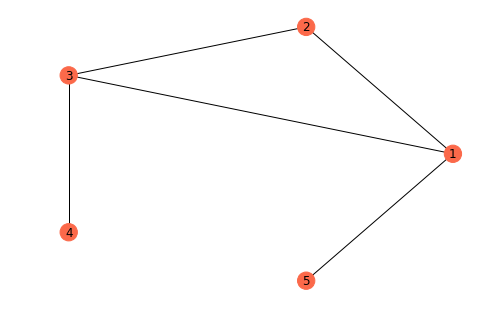

In [22]:
%matplotlib inline

# Function for visualizing graph
def graph_visualize(V, E, valmin=0, valmax=1, values=None):
    """
    V: list of vertices
    E: list of edges (each edge is a tuple of vertices)
    """
    
    # Create an empty graph object
    G = nx.Graph()
    
    # Add the vertices to G
    G.add_nodes_from(V)
    
    # Add the edges to G
    G.add_edges_from(E)
    
    # Draw the graph
    if values is None:
        values = len(G.nodes()) * [0.5]
        nx.draw_circular(G, with_labels=True, cmap=plt.get_cmap('Reds'), node_color=values, vmin=valmin, vmax=valmax)
    else:
        nx.draw_circular(G, with_labels=True, cmap=plt.get_cmap('Reds'), node_color=values, vmin=valmin, vmax=valmax)

if __name__ == "__main__":
    
    # Create vertex list
    V = [1, 2, 3, 4, 5]
    
    # Create edge list
    E = [(1, 2), (1, 3), (2, 3), (3, 4), (1, 5)]
    
    # Create list of node values
    values = [1, 20, -2.5, 0, 2]
    
    # Print vertex and edge information
    print("List of vertices:", V)
    print("List of edges:", E)
    print("List of node values:", values)
    
    # Visualize the graph
    print("\nDrawing the graph")
    graph_visualize(V, E)

The following Python code solves the weighted vertex cover problem using ```ortools```.

List of vertices in the graph: [1, 2, 3, 4, 5]
List of edges in the graph: [(1, 2), (1, 3), (2, 3), (3, 4), (1, 5)]


The selected vertices are:
1
3
4


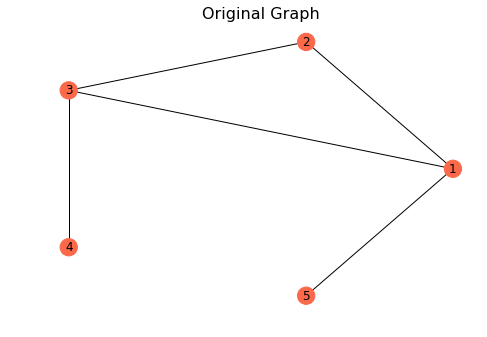

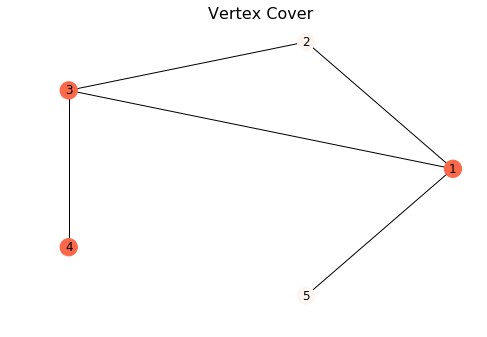

In [23]:
from ortools.linear_solver import pywraplp

def weighted_vertex_cover():
    
    # Represent the problem data
    V = [1, 2, 3, 4, 5]
    E = [(1, 2), (1, 3), (2, 3), (3, 4), (1, 5)]
    
    # Print the problem data
    print("List of vertices in the graph:", V)
    print("List of edges in the graph:", E)
    
    # Instantiate a mixed-integer solver, naming it Weighted-Set-Cover
    solver = pywraplp.Solver('Weighted-Vertex-Cover', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    # Define integer binary variables.
    x1 = solver.IntVar(0, 1, '1')
    x2 = solver.IntVar(0, 1, '2')
    x3 = solver.IntVar(0, 1, '3')
    x4 = solver.IntVar(0, 1, '4')
    x5 = solver.IntVar(0, 1, '5')
    
    # Constraint 1 (edge (1,2) is covered): x1 + x2 >= 1
    constraint1 = solver.Constraint(1, solver.infinity())
    constraint1.SetCoefficient(x1, 1)
    constraint1.SetCoefficient(x2, 1)
    
    # Constraint 2 (edge (1,3) is covered): x1 + x3 >= 1
    constraint2 = solver.Constraint(1, solver.infinity())
    constraint2.SetCoefficient(x1, 1)
    constraint2.SetCoefficient(x3, 1)
    
    # Constraint 3 (edge (2,3) is covered): x2 + x3 >= 1
    constraint3 = solver.Constraint(1, solver.infinity())
    constraint3.SetCoefficient(x2, 1)
    constraint3.SetCoefficient(x3, 1)
    
    # Constraint 4 (edge (3,4) is covered): x3 + x4 >= 1
    constraint4 = solver.Constraint(1, solver.infinity())
    constraint4.SetCoefficient(x3, 1)
    constraint4.SetCoefficient(x4, 1)
    
    # Constraint 5 (edge (1,5) is covered): x1 + x5 >= 1
    constraint5 = solver.Constraint(1, solver.infinity())
    constraint5.SetCoefficient(x1, 1)
    constraint5.SetCoefficient(x5, 1)
    
    # Minimize 1 * x1 + 20 * x2 - 2.5 * x3 + 0 * x4 + 2 * x5
    objective = solver.Objective()
    objective.SetCoefficient(x1, 1)
    objective.SetCoefficient(x2, 20)
    objective.SetCoefficient(x3, -2.5)
    objective.SetCoefficient(x4, 0)
    objective.SetCoefficient(x5, 2)
    objective.SetMinimization()
    
    # Solve the problem and verify the problem has an optimal solution
    result_status = solver.Solve()
    assert result_status == pywraplp.Solver.OPTIMAL
    
    # Print the selected subsets in the optimal solution, and extract the optimal value of all variables
    print("\n")
    print("The selected vertices are:")
    values_opt = []
    for item in ['1', '2', '3', '4', '5']:
        var = solver.LookupVariable(item)
        values_opt.append(var.solution_value())
        if var.solution_value() == 1:
            print(item)
    
    # Display solution
    graph_visualize(V, E)
    plt.title("Original Graph", fontsize=16)
    plt.show()
    
    graph_visualize(V, E, 0, 2, values_opt)
    plt.title("Vertex Cover", fontsize=16)
    plt.show()

if __name__ == "__main__":
    weighted_vertex_cover()

***
### Example 3: Weighted Set Cover
The **weighted set cover** problem is another classic problem in combinatorial optimization. Suppose that we are given a finite set $\mathcal{S}$ of elements, and another subset $\mathcal{T}$ of the power set of $\mathcal{S}$, i.e. $\mathcal{T} \subset 2^{\mathcal{S}}$, with the property that $\bigcup\limits_{t \in \mathcal{T}} t = \mathcal{S}$. There is also a cost function $w : \mathcal{T} \rightarrow \mathbb{R}$. The goal is to find a subset of $\mathcal{T}$ that covers all the elements in $\mathcal{S}$, such that the total sum of the costs of the selected elements of $\mathcal{T}$ is minimized.

Formally our goals can be expressed as an integer (binary) optimization problem. Assign a binary variable $x_t \in \{0,1\}$ for every element $t \in \mathcal{T}$, which will be referred to as **subset indicator variables**. Also for all $t \in \mathcal{T}$, and $s \in \mathcal{S}$, we define $c_{ts} = 1$ if $s \in t$, and $c_{ts} = 0$ if $s \notin t$. Then our weighted set cover problem goals can be expressed by the following ILP:

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & \sum_{t \in \mathcal{T}} w(t) \; x_t  \\
\text{subject to} \;\; & \sum_{t \in \mathcal{T}} c_{ts} x_t \geq 1, \;\; \forall \;\; s \in \mathcal{S}  \\
& x_t \in \{0,1\}, \;\; \forall \;\; t \in \mathcal{T}.
\end{split}
\end{equation}
$$

The first constraint expresses the fact that each element $s \in \mathcal{S}$ is covered by at least one element $t \in \mathcal{T}$, which is the **set cover** constraint, from which the problem derives its name.

Let us take a concrete example. Suppose $\mathcal{S} = \{1,2,3,4,5,6,7\}$, and let $\mathcal{T} = \{a,b,c,d,e\}$, where 

$$
\begin{equation}
\begin{split}
a &= \{1,2,3\} \\
b &= \{3,4,6\} \\
c &= \{4,5\} \\
d &= \{2,5,6,7\}.
\end{split}
\end{equation}
$$

We will represent $c_{ts}$ using a cost matrix $C$ defined below, with rows indexing elements of $\mathcal{T}$, and columns indexing elements of $\mathcal{S}$,

$$
C = 
\begin{bmatrix}
1 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 1 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 1 & 1
\end{bmatrix}
\;\;.
$$

Also let the cost function $w$ be the constant function $w(t) = 1$, for all $t \in \mathcal{T}$, which corresponds to the **original set cover** problem, that seeks to minimize the number of selected subsets that cover the set $\mathcal{S}$.

Here is the full Python code that solves the problem using ```ortools```.

In [24]:
from ortools.linear_solver import pywraplp

def weighted_set_cover():
    
    # Represent the problem data
    S = [1, 2, 3, 4, 5, 6, 7]
    T = {'a':{1, 2, 3}, 'b':{3, 4, 6}, 'c':{4, 5}, 'd':{2, 5, 6, 7}}
    
    # Print the problem
    print("The set S of elements:")
    for item in S:
        print(item)
    
    print("\n")
    print("The set T of subsets of S:")
    for key, val in T.items():
        print(key, ":", val)
    
    # Instantiate a mixed-integer solver, naming it Weighted-Set-Cover
    solver = pywraplp.Solver('Weighted-Set-Cover', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    # Define integer binary variables.
    xa = solver.IntVar(0, 1, 'a')
    xb = solver.IntVar(0, 1, 'b')
    xc = solver.IntVar(0, 1, 'c')
    xd = solver.IntVar(0, 1, 'd')
    
    # Constraint 1: xa >= 1
    constraint1 = solver.Constraint(1, solver.infinity())
    constraint1.SetCoefficient(xa, 1)
    
    # Constraint 2: xa + xd >= 1
    constraint2 = solver.Constraint(1, solver.infinity())
    constraint2.SetCoefficient(xa, 1)
    constraint2.SetCoefficient(xd, 1)
    
    # Constraint 3: xa + xb >= 1
    constraint3 = solver.Constraint(1, solver.infinity())
    constraint3.SetCoefficient(xa, 1)
    constraint3.SetCoefficient(xb, 1)
    
    # Constraint 4: xb + xc >= 1
    constraint4 = solver.Constraint(1, solver.infinity())
    constraint4.SetCoefficient(xb, 1)
    constraint4.SetCoefficient(xc, 1)
    
    # Constraint 5: xc + xd >= 1
    constraint5 = solver.Constraint(1, solver.infinity())
    constraint5.SetCoefficient(xc, 1)
    constraint5.SetCoefficient(xd, 1)
    
    # Constraint 6: xb + xd >= 1
    constraint6 = solver.Constraint(1, solver.infinity())
    constraint6.SetCoefficient(xb, 1)
    constraint6.SetCoefficient(xd, 1)
    
    # Constraint 7: xd >= 1
    constraint6 = solver.Constraint(1, solver.infinity())
    constraint6.SetCoefficient(xd, 1)
    
    # Minimize xa + xb + xc + xd
    objective = solver.Objective()
    objective.SetCoefficient(xa, 1)
    objective.SetCoefficient(xb, 1)
    objective.SetCoefficient(xc, 1)
    objective.SetCoefficient(xd, 1)
    objective.SetMinimization()
    
    # Solve the problem and verify the problem has an optimal solution
    result_status = solver.Solve()
    assert result_status == pywraplp.Solver.OPTIMAL
    
    # Print the selected subsets in the optimal solution
    print("\n")
    print("The selected subsets are:")
    for item in ['a', 'b', 'c', 'd']:
        var = solver.LookupVariable(item)
        if var.solution_value() == 1:
            print(item, ":", T[item])

if __name__ == "__main__":
    weighted_set_cover()

The set S of elements:
1
2
3
4
5
6
7


The set T of subsets of S:
a : {1, 2, 3}
b : {3, 4, 6}
c : {4, 5}
d : {2, 5, 6, 7}


The selected subsets are:
a : {1, 2, 3}
b : {3, 4, 6}
d : {2, 5, 6, 7}


***
## Bin packing: multidimensional knapsack
Bin packing refers to the problem of finding a set of objects to pack into bins. The objects have **volumes**, and each bin has a **capacity**, which is the total volume the container can hold. We discuss the multidimensional knapsack problem here, which is arguably the most famous bin packing problem. More information on solving bin packing problems using ```ortools``` can be found <a href="https://developers.google.com/optimization/bin" style="text-decoration: none;">here</a>.

### Multidimensional knapsack
The setting involves a finite set of objects $\mathcal{S}$, each with $n + 1$ attributes. The first $n$ attributes are **volumes** (or some other property) of each object along $n$ different dimensions, and the last attribute is the **value** of each object. There is a **knapsack** (or container) which also has $n$ attributes associated with it (called **capacities**), and correspond to the total volume of objects that can fit along each dimension in the knapsack. The objective of the problem is to choose objects from $\mathcal{S}$ to put into the knapsack, such that the total value of all the objects is as large as possible, and the total volume of the selected objects do not exceed the capacity of the knapsack along any dimension.

Mathematically the knapsack problem is equivalent to an ILP. We briefly mention this formulation here, as it shows the combinatorial structure of the problem. Assign a binary variable $x_s \in \{0,1\}$ for each element $s \in \mathcal{S}$. Let $v_s$ denote the value, and $c_{d,s}$ denote the volume along dimension $d$, of each element $s \in \mathcal{S}$. Also let $C_d$ denote the capacity of the knapsack along dimension $d$. Then the goals of multidimensional knapsack are expressed by the following optimization problem:

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & \sum_{s \in \mathcal{S}} x_s v_s  \\
\text{subject to} \;\; & \sum_{s \in \mathcal{S}} c_{d,s} x_s \leq C_d, \;\; \forall \;\; 1 \leq d \leq n  \\
& x_s \in \{0,1\}, \;\; \forall \;\; s \in \mathcal{S}.
\end{split}
\end{equation}
$$

While this problem can be certainly solved using the techniques developed in the last section on MILP, ```ortools``` provides a specialized solver called ```KnapsackSolver``` to solve this problem. The reader can find more details about using the solver on the <a href="https://developers.google.com/optimization/bin/knapsack" style="text-decoration: none;">documentation page</a>. One thing to note is that ```KnapsackSolver``` only accepts **non-negative integer values** for values, volumes and capacities.

We demonstrate how to use the solver using a simple example. But let us first import the python wrapper ```pywrapknapsack_solver``` for the underlying C++ solver using the following Python code.

In [25]:
from ortools.algorithms import pywrapknapsack_solver

### Example 1
Consider an instance of multidimensional knapsack in 2 dimensions ($d = 2$), where $\mathcal{S} = \{a, b, c, d, e\}$, and the knapsack capacities are $C_1 = 10, C_2 = 15$. Let the values of the objects be given by the following table:

|  $s$ | $v_s$ |
|------|-------|
|  $a$ |  $2$  |
|  $b$ |  $10$ |
|  $c$ |  $5$  |
|  $d$ |  $4$  |
|  $e$ |  $3$  |

Let the volumes of the objects be given by the following table:

|  $s$ | $c_{1,s}$ | $c_{2,s}$ |
|------|-------|-------|
|  $a$ |  $1$  |  $3$  |
|  $b$ |  $6$  |  $6$  |
|  $c$ |  $3$  |  $8$  |
|  $d$ |  $2$  |  $1$  |
|  $e$ |  $5$  |  $4$  |

The problem can then be solved using ```ortools``` by following the steps as shown below.

**Declare the values, volumes, and capacities**

The ```KnapsackSolver``` accepts the data to be in a certain format. The values should be a list of the same length as the number of objects, while the capacities should be a list of length equal to the number of dimensions. The volumes of the objects should be a list of lists. The outer list need to have the same length as the number of dimensions, while each inner list must have the same length as the number of objects.

In [26]:
# Store the name of elements (this is not needed for the solver, but useful to display results)
objects = ['a', 'b', 'c', 'd', 'e']

# Declare the values, volumes and capacities
values = [2, 10, 5, 4, 3]
volumes = [[1, 6, 3, 2, 5], [3, 6, 8, 1, 4]]
capacities = [10, 15]

**Create an instance of ```KnapsackSolver```**

The next step is to create an instance of ```KnapsackSolver```. It is important to use ```KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER``` as shown below. Other options include ```KNAPSACK_DYNAMIC_PROGRAMMING_SOLVER```, but it can only solve 1 dimensional knapsacks.

In [27]:
# Create the solver, name it Example1
solver = pywrapknapsack_solver.KnapsackSolver(
    pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
    'Example1'
)

**Initialize the solver with the data**

The next step feeds the problem data into the solver.

In [28]:
# Initialize the solver
solver.Init(values, volumes, capacities)

**Solve the problem**

In [29]:
# Solve the problem
computed_value = solver.Solve()

**Display the results**

We can display the results as follows.

In [30]:
# Display results
packed_items = [objects[x] for x in range(0, len(objects)) if solver.BestSolutionContains(x)]
packed_volumes = [
    [volumes[0][x] for x in range(0, len(objects)) if solver.BestSolutionContains(x)], 
    [volumes[1][x] for x in range(0, len(objects)) if solver.BestSolutionContains(x)]
]
total_volumes = [sum(packed_volumes[0]), sum(packed_volumes[1])]

print("The maximum possible knapsack value is", computed_value)
print("Packed items: ", packed_items)
print("Total volumes: ", total_volumes)

The maximum possible knapsack value is 16
Packed items:  ['a', 'b', 'd']
Total volumes:  [9, 10]


Here is the full Python code in one place.

In [31]:
from ortools.algorithms import pywrapknapsack_solver

def multiknapsack(objects, values, volumes, capacities, name="multiknapsack"):
    
    # Create the solver, name it Example1
    solver = pywrapknapsack_solver.KnapsackSolver(
        pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
        name
    )

    # Initialize the solver
    solver.Init(values, volumes, capacities)
    
    # Solve the problem
    computed_value = solver.Solve()
    
    # Display results
    packed_items = [objects[x] for x in range(0, len(objects)) if solver.BestSolutionContains(x)]
    packed_volumes = [
        [volumes[0][x] for x in range(0, len(objects)) if solver.BestSolutionContains(x)], 
        [volumes[1][x] for x in range(0, len(objects)) if solver.BestSolutionContains(x)]
    ]
    total_volumes = [sum(packed_volumes[0]), sum(packed_volumes[1])]
    
    print("The maximum possible knapsack value is", computed_value)
    print("Packed items: ", packed_items)
    print("Total volumes: ", total_volumes)

if __name__ == '__main__':
    
    # Store the name of elements (this is not needed for the solver, but useful to display results)
    objects = ['a', 'b', 'c', 'd', 'e']

    # Declare the values, volumes and capacities
    values = [2, 10, 5, 4, 3]
    volumes = [[1, 6, 3, 2, 5], [3, 6, 8, 1, 4]]
    capacities = [10, 15]
    
    # Solve
    multiknapsack(objects=objects, values=values, volumes=volumes, capacities=capacities, name="Example1")

The maximum possible knapsack value is 16
Packed items:  ['a', 'b', 'd']
Total volumes:  [9, 10]


***
### Exercise 2
Consider the 1 dimensional knapsack problem with the following data.

In [32]:
# Store the name of elements
objects = ['a', 'b', 'c', 'd', 'e']

# Declare the values, volumes and capacities
values = [2, 10, 5, 4, 3]
volumes = [[1, 6, 3, 2, 5]]
capacities = [10]

Solve the problem in three different ways:
- Using ```pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER```.
- Using ```pywrapknapsack_solver.KnapsackSolver.KNAPSACK_DYNAMIC_PROGRAMMING_SOLVER```.
- Using ```pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING```.

Time the different solvers.

In [33]:
# Write your code here

***
## Constraint programming
**Constraint programming (CP)** or **constraint optimization** refers to the task of finding feasible solutions to a set of arbitrary constraints, and such problems arise in many science and engineering applications. Thus CP is distinctly different from optimization problems; in fact in most cases, a CP may not even have an objective function, and the goal is to simply narrow down a large set of possible solutions to a more manageable subset by adding constraints to the problem. In fact, CP may arise as a subproblem in the solution process of an optimization problem. It should be noted however that any optimization problem can be solved this way by simply checking the objective function value at all the feasible solutions, and choosing the one that is the best. However this may be highly inefficient and hence is not recommended in most cases.

```ortools``` provides two libraries for solving CP problems:
- ```CP-SAT``` solver (SAT stands for **satisfiability**)
- ```original CP``` solver.

The recommended CP solver from Google is the ```CP-SAT``` solver, as it is much faster than the ```original CP``` solver, and we will strictly focus on the former in this lecture. More information on the two solvers, and some solved examples using each of them can be found by starting on the <a href="https://developers.google.com/optimization/cp/cp_solver" style="text-decoration: none;">documentation page</a> of the solvers. We will demonstrate the usage and syntax for ```CP-SAT``` using some examples. Most of the examples that we have chosen to illustrate are slight variants of the examples provided by ```ortools```, so that the reader can find more extensive discussion of these problems from online resources. This <a href="https://github.com/google/or-tools/blob/master/ortools/sat/doc/index.md" style="text-decoration: none;">reference page</a> also contains extensive documentation.

It should be noted that the ```CP-SAT``` solver only works on integer data. However in most cases CP problems with non-integer data can be converted to CP problems with integer data using the techniques described for example <a href="https://developers.google.com/optimization/mip/integer_opt_cp" style="text-decoration: none;">here</a>.

The python wrappers ```cp_model``` and ```pywrapcp``` provide access to the underlying C++ solver for the ```CP-SAT``` solver and the ```original CP``` solver respectively. Let us import them, although we will not be using ```pywrapcp```.

In [34]:
from ortools.sat.python import cp_model
from ortools.constraint_solver import pywrapcp

***
### Exercise 3
It is very instructive to read through the code implementing the Python interface ```cp_model```, as described here:

<a href="https://github.com/google/or-tools/blob/master/ortools/sat/python/cp_model.py" style="text-decoration: none;">https://github.com/google/or-tools/blob/master/ortools/sat/python/cp_model.py</a>.

***
### Example 1
We work through the first example in detail to understand the basic syntax of ```CP-SAT```.

Consider the following feasibility problem:

$$
\begin{equation}
\begin{split}
\text{find} \;\; & x, y  \\
\text{subject to} \;\; & x \neq y  \\
& x + y \leq 4  \\
& 1 \leq 2x + y \leq 5  \\
& x, y \in \{0,1,2,3\}.
\end{split}
\end{equation}
$$

The steps to model this problem using ```CP-SAT``` and solve it are explained below.

### Instantiate the solver
We need to create two objects - the ```model``` and the ```solver```, the first of which is used to model the problem, such as all the data and the constraints, while the second one solves the problem.

In [35]:
# Create the model and solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

### Create the variables
We then create the variables involved in the problem. Here we only need ```NewIntVar``` for the problem.

**Note: Many other kinds of variables are available. You can see them by browsing the list after typing ```model.``` and pressing ```tab```.**

In [36]:
# Create the variables
num_values = 4
x = model.NewIntVar(0, num_values - 1, "x")
y = model.NewIntVar(0, num_values - 1, "y")

### Create the constraints
The next step is to create the constraints of the problem.

In [37]:
# Create the constraints

# Constraint 1: x != y
constraint1 = model.Add(x != y)

# Constraint 2: x + y <= 4
constraint2 = model.Add(x + y <= 4)

# Constraint 3: 1 <= 2x + y <= 5
constraint3 = model.AddLinearConstraint(terms=[(x, 2), (y, 1)], lb=1, ub=5)

### Create the solution printer
The ```CP-SAT``` solver displays the results using a **solution printer**. The solution printer is a callback defined in a Python class, which we pass to the solver as shown below, and the callback is executed each time a new solution is found. It needs to be implemented as a class inherited from ```CpSolverSolutionCallback```. It is highly recommended that you check the code <a href="https://github.com/google/or-tools/blob/master/ortools/sat/python/cp_model.py" style="text-decoration: none;">here</a>. The method ```NewSolution``` must be implemented which gets called everytime the solver finds a new solution.

In [38]:
# Create the SolutionPrinter class
class SolutionPrinter(cp_model.CpSolverSolutionCallback):

    """
    Print intermediate solutions.
    """

    def __init__(self, variables):
        self.__variables = variables
        self.__solution_count = 0

    def NewSolution(self):
        self.__solution_count += 1
        for v in self.__variables:
            print('%s = %i,' % (v, self.Value(v)), end = ' ')
        print()

    def SolutionCount(self):
        return self.__solution_count

# Create a solution printer
solution_printer = SolutionPrinter([x, y])

### Call the solver
We can finally solve the problem by calling the solver. Here we will search for all solutions by using the method ```SearchForAllSolutions```.

In [39]:
# Call the solver, verify solution and pront results
print("Solving the CP problem...\n")
print("Printing all solutions...")
status = solver.SearchForAllSolutions(model, solution_printer)
assert status == cp_model.FEASIBLE
print('\nNumber of solutions found: %i' % solution_printer.SolutionCount())

Solving the CP problem...

Printing all solutions...
x = 1, y = 0, 
x = 2, y = 0, 
x = 2, y = 1, 
x = 0, y = 1, 
x = 0, y = 2, 
x = 0, y = 3, 
x = 1, y = 2, 
x = 1, y = 3, 

Number of solutions found: 8


***
### Example 2
This example illustrates how to implement ```AND``` and ```OR``` constraints. Consider the following feasibility problem:

$$
\begin{equation}
\begin{split}
\text{find} \;\; & x, y, z  \\
\text{subject to} \;\; & (x \neq y) \;\&\; (y \neq z) \;\&\; (z \neq x)  \\
& (x + y + z \leq 4) \text{ or } (1 \leq 2x + y \leq 5) \\
& x, y, z \in \{0,1,2,3\}.
\end{split}
\end{equation}
$$

The following Python code then solves this problem using **channeling constraints**, as described <a href="https://github.com/google/or-tools/blob/master/ortools/sat/doc/channeling.md" style="text-decoration: none;">here</a>.

In [40]:
# Solution to Example 2

def cp_example2():
    
    ###############################################
    # Create the model and solver
    model = cp_model.CpModel()
    solver = cp_model.CpSolver()
    
    ###############################################
    # Create the variables
    num_values = 4
    x = model.NewIntVar(0, num_values - 1, "x")
    y = model.NewIntVar(0, num_values - 1, "y")
    z = model.NewIntVar(0, num_values - 1, "z")
    
    # Create boolean variable needed to implement the OR constraint
    b = model.NewBoolVar("b")
    
    ###############################################
    # Create the constraints
    #----------------------------------------------
    # Constraint 1: (x != y) & (y != z) & (z != x)
    model.AddAllDifferent([x, y, z])
    
    #----------------------------------------------
    # Constraint 2: (x + y + z <= 4) or (1 <= 2x + y <= 5)
    model.Add(x + y + z <= 4).OnlyEnforceIf(b)
    model.Add(x + y + z > 4).OnlyEnforceIf(b.Not())
    model.AddLinearConstraint(terms=[(x, 2), (y, 1)], lb=1, ub=5).OnlyEnforceIf(b.Not())
    
    ###############################################
    # Create a solution printer
    solution_printer = SolutionPrinter([x, y, z, b])
    
    # Call the solver, verify solution and pront results
    print("Solving the CP problem...\n")
    print("Printing all solutions...")
    status = solver.SearchForAllSolutions(model, solution_printer)
    assert status == cp_model.FEASIBLE
    print('\nNumber of solutions found: %i' % solution_printer.SolutionCount())

if __name__ == "__main__":
    cp_example2()

Solving the CP problem...

Printing all solutions...
x = 0, y = 2, z = 3, b = 0, 
x = 1, y = 2, z = 3, b = 0, 
x = 2, y = 0, z = 3, b = 0, 
x = 2, y = 1, z = 3, b = 0, 
x = 2, y = 1, z = 0, b = 1, 
x = 3, y = 1, z = 0, b = 1, 
x = 1, y = 3, z = 2, b = 0, 
x = 0, y = 3, z = 2, b = 0, 
x = 0, y = 3, z = 1, b = 1, 
x = 1, y = 3, z = 0, b = 1, 
x = 1, y = 2, z = 0, b = 1, 
x = 0, y = 1, z = 2, b = 1, 
x = 0, y = 2, z = 1, b = 1, 
x = 0, y = 1, z = 3, b = 1, 
x = 1, y = 0, z = 3, b = 1, 
x = 1, y = 0, z = 2, b = 1, 
x = 2, y = 0, z = 1, b = 1, 
x = 3, y = 0, z = 1, b = 1, 

Number of solutions found: 18


***
### Example 3: SAT problems with constraints
Find a solution to the following **conjunctive normal form** (CNF) involving binary $\{0,1\}$ variables:

$$
(x_1 \lor x_2 \lor x_4) \land (\neg x_3 \lor x_5 \lor x_4) \land (x_2 \lor \neg x_4 \lor x_6) \land (x_1 \lor x_4 \lor x_5)
$$

subject to the additional constraint that

$$
x_2 \implies (x_5 \lor x_3) \land x_6.
$$

This is a specific instance of a 3-SAT problem with constraints. To solve this problem we need to use **reified constraints**. The Python code is given below.

In [41]:
# Solution to Example 3

def cp_example3():
    
    ###############################################
    # Create the model and solver
    model = cp_model.CpModel()
    solver = cp_model.CpSolver()
    
    ###############################################
    # Create the boolean variables
    x1 = model.NewBoolVar("x1")
    x2 = model.NewBoolVar("x2")
    x3 = model.NewBoolVar("x3")
    x4 = model.NewBoolVar("x4")
    x5 = model.NewBoolVar("x5")
    x6 = model.NewBoolVar("x6")
    
    ###############################################
    # Create the constraints
    #----------------------------------------------
    # Constraint 1: 3-SAT clause
    model.AddBoolOr([x1, x2, x4])
    model.AddBoolOr([x3.Not(), x5, x4])
    model.AddBoolOr([x2, x4.Not(), x6])
    model.AddBoolOr([x1, x4, x5])
    
    #----------------------------------------------
    # Constraint 2: x2 => (x5 OR x3) & x6
    
    # Create extra boolean variables to implement constraints
    y1 = model.NewBoolVar("y1")
    y2 = model.NewBoolVar("y2")
    
    model.AddBoolOr([x5, x3]).OnlyEnforceIf(y1)
    model.AddBoolAnd([x5.Not(), x3.Not()]).OnlyEnforceIf(y1.Not())
    model.AddBoolAnd([y1, x6]).OnlyEnforceIf(y2)
    model.AddBoolOr([y1.Not(), x6.Not()]).OnlyEnforceIf(y2.Not())
    model.AddImplication(x2, y2)
    
    """
    #---------------DIFFERENT WAY------------------
    # Constraint 2: x2 => (x5 OR x3) & x6
    
    # Create extra boolean variables to implement constraints
    y1 = model.NewBoolVar("y1")
    
    model.AddBoolOr([x5, x3]).OnlyEnforceIf(y1)
    model.AddBoolAnd([x5.Not(), x3.Not()]).OnlyEnforceIf(y1.Not())
    model.AddImplication(x2, y1)
    model.AddImplication(x2, x6)
    """
    
    ###############################################
    # Create a solution printer
    solution_printer = SolutionPrinter([x1, x2, x3, x4, x5, x6])
    
    # Call the solver, verify solution and pront results
    print("Solving the CP problem...\n")
    print("Printing all solutions...")
    status = solver.SearchForAllSolutions(model, solution_printer)
    assert status == cp_model.FEASIBLE
    print('\nNumber of solutions found: %i' % solution_printer.SolutionCount())

if __name__ == "__main__":
    cp_example3()

Solving the CP problem...

Printing all solutions...
x1 = 0, x2 = 0, x3 = 0, x4 = 1, x5 = 0, x6 = 1, 
x1 = 1, x2 = 0, x3 = 0, x4 = 1, x5 = 0, x6 = 1, 
x1 = 1, x2 = 0, x3 = 1, x4 = 1, x5 = 0, x6 = 1, 
x1 = 0, x2 = 0, x3 = 1, x4 = 1, x5 = 0, x6 = 1, 
x1 = 0, x2 = 0, x3 = 1, x4 = 1, x5 = 1, x6 = 1, 
x1 = 1, x2 = 0, x3 = 1, x4 = 1, x5 = 1, x6 = 1, 
x1 = 1, x2 = 0, x3 = 0, x4 = 1, x5 = 1, x6 = 1, 
x1 = 0, x2 = 0, x3 = 0, x4 = 1, x5 = 1, x6 = 1, 
x1 = 0, x2 = 1, x3 = 0, x4 = 1, x5 = 1, x6 = 1, 
x1 = 1, x2 = 1, x3 = 0, x4 = 1, x5 = 1, x6 = 1, 
x1 = 1, x2 = 1, x3 = 1, x4 = 1, x5 = 1, x6 = 1, 
x1 = 0, x2 = 1, x3 = 1, x4 = 1, x5 = 1, x6 = 1, 
x1 = 0, x2 = 1, x3 = 1, x4 = 1, x5 = 0, x6 = 1, 
x1 = 1, x2 = 1, x3 = 1, x4 = 1, x5 = 0, x6 = 1, 
x1 = 1, x2 = 0, x3 = 1, x4 = 0, x5 = 1, x6 = 1, 
x1 = 1, x2 = 0, x3 = 0, x4 = 0, x5 = 1, x6 = 1, 
x1 = 1, x2 = 0, x3 = 0, x4 = 0, x5 = 0, x6 = 1, 
x1 = 1, x2 = 1, x3 = 0, x4 = 0, x5 = 1, x6 = 1, 
x1 = 0, x2 = 1, x3 = 0, x4 = 0, x5 = 1, x6 = 1, 
x1 = 0, x2 = 1, 

***
### Example 4: Integer optimization
CP can also be used to solve integer optimization problems in many cases. Consider the ILP:

$$
\begin{equation}
\begin{split}
\text{maximize} \;\; & x_1 + 2 x_2 - 3 x_3 + x_4  \\
\text{subject to} \;\; & 3 x_2 + x_4 + x_5 \leq 10 \\
& x_1 + x_3 + x_4 \leq 15 \\
& x_1, x_2, x_3 \in \{1,2,3,4\} \\
& x_4, x_5 \in \{0,1,2,3,4\}.
\end{split}
\end{equation}
$$

Here is the Python code that solves this problem using the ```CP-SAT``` solver.

In [42]:
# Solution to Example 4

def cp_example4():
    
    # Create the model and solver
    model = cp_model.CpModel()
    solver = cp_model.CpSolver()
    
    # Create the variables
    x1 = model.NewIntVar(1, 4, "x1")
    x2 = model.NewIntVar(1, 4, "x2")
    x3 = model.NewIntVar(1, 4, "x3")
    x4 = model.NewIntVar(0, 4, "x4")
    x5 = model.NewIntVar(0, 4, "x5")
    
    # Create the constraints
    
    # Constraint 1: 3 * x2 + x4 + x5 <= 10
    model.AddLinearConstraint(terms=[(x2, 3), (x4, 1), (x5, 1)], lb=0, ub=10)
    
    # Constraint 2: x1 + x3 + x4 <= 15
    model.AddSumConstraint([x1, x3, x4], lb=0, ub=15)
    
    # Create the objective: x1 + 2 * x2 - 3 * x3 + x4
    model.Maximize(x1 + 2 * x2 - 3 * x3 + x4)
    
    # Call the solver
    print("Solving the CP problem...\n")
    status = solver.Solve(model)
    
    # Verify solution and print result
    assert status == cp_model.OPTIMAL
    print("Optimal objective value:", solver.ObjectiveValue())
    for var in [x1, x2, x3, x4, x5]:
        print(var.name(), "=", solver.Value(var))

if __name__ == "__main__":
    cp_example4()

Solving the CP problem...

Optimal objective value: 9.0
x1 = 4
x2 = 2
x3 = 1
x4 = 4
x5 = 0


***
### Exercise 4: N-queens problem
Study the N-queen's problem as described on the <a href="https://developers.google.com/optimization/cp/queens" style="text-decoration: none;">documentation page</a>. The problem is solved there using the ```original CP solver```. Solve it using ```CP-SAT``` solver.

In [43]:
# Write your code here

***
## Scheduling problems
Many optimization problems involving assigning resources to perform a set of specific tasks, and at different times, frequently arise in the manufacturing industries, as well in the transportation and delivery sector. These problems are broadly classified under the umbrella of **scheduling problems**. Typically, the goal of such problems is to find a schedule that minimizes the total amount of time (or cost) required to complete all the tasks.

The ```CP-SAT``` solver is capable of solving many such problems. Two specific problems that is somewhat widely applciable are:
- <a href="https://developers.google.com/optimization/scheduling/job_shop" style="text-decoration: none;">The job shop problem</a>.
- <a href="https://developers.google.com/optimization/scheduling/employee_scheduling" style="text-decoration: none;">The employee scheduling problem</a>.

The documentation of ```ortools``` guides you on how to solve these problems using the ```original CP solver```. In this tutorial, we will cover how to solve the **job shop problem** using ```CP-SAT```. You will be asked to do the same for the **employee scheduling problem** as an exercise. It is good to know both these problems, as they are extremely common.

***
### Example 1: The job shop problem
Let us first describe the basic setup of the job shop problem. We have a finite set of jobs $J_1, \dots, J_N$, and each job has associated to it a finite set of tasks. So for the $i^{\text{th}}$ job $J_i$, we have the tasks $T_i = \{t_{i,1}, \dots, t_{i,m_i}\}$, and all the $m_i$ need not be the same, for all $1 \leq i \leq N$. We also have a finite set $P$ of processors on which the tasks can be executed, $P = \{p_1,\dots,p_M\}$. Next for each $i$, $1 \leq i \leq N$, we have a map $f_i: T_i \rightarrow P$, from the set of tasks to the set of processors and another function $g_i: T_i \rightarrow \mathbb{N}$, which signifies the amount of time taken by each task to complete.

The basic task in the job shop scheduling problem is to create a plan of execution of all the tasks on the given processors, subject to the following constraints:
- For each job $J_i$, if $1 \leq j_1 < j_2 \leq m_i$, then task $t_{i,j_2}$ can only start after task $t_{i,j_1}$ has finished completely.
- Every task $t_{i,j}$ must necessarily execute on the processor $f_i(t_{i,j})$.
- Only one task can be executed on a processor at any given time.

The goal then is to minimize the total time of completion for all the jobs.

**Note: In general the times taken by the tasks need not be integers, but we need this to be able to solve this problem using ```CP-SAT```.**

In order to solve this problem, let us assign a non-negative integer variable $x_{i,j}$ that denotes the start time for task $t_{i,j}$, for all $i,j$. We will assume that each task has been assigned to the correct processor, and so there will not be a need to implement this constraint explicitly. The goals of the job shop scheduling problem can be expressed as the following combinatorial **minimax** problem:

$$
\begin{equation}
\begin{split}
\text{minimize} \;\; & \max \{x_{i,j} + g_i(t_{i,j}) : 1 \leq i \leq N, 1 \leq j \leq m_i \}  \\
\text{subject to} \;\; & x_{i,j} + g_i(t_{i,j}) \leq x_{i,j+1}, \; \forall \; 1 \leq i \leq N, 1 \leq j \leq m_i - 1 \\
& \left( x_{i_1,j_1} + g_{i_1}(t_{i_1,j_1}) \leq x_{i_2,j_2} \right) \; \text{or} \; \left( x_{i_2,j_2} + g_{i_2}(t_{i_2,j_2}) \leq x_{i_1,j_1} \right), \; \forall \; i_1, i_2, j_1, j_2, \text{ such that } \; f_{i_1}(t_{i_1,j_1}) = f_{i_2}(t_{i_2,j_2}) \\
& x_{i,j} \in \mathbb{N}, \; \forall \; 1 \leq i \leq N, 1 \leq j \leq m_i.
\end{split}
\end{equation}
$$

We take the specific instance of the job shop scheduling problem described <a href="https://developers.google.com/optimization/scheduling/job_shop" style="text-decoration: none;">here</a>. The following Python code then solves this problem using ```CP-SAT```.

In [44]:
# Solution to the job shop problem

def job_shop_cpsat(machines, processing_times):
    
    """
    Machines and processing times need to have the same shape
    """
    
    ###############################################
    # Get number of jobs
    num_jobs = len(machines)
    
    # Get processor ids and number of different processors
    procs = []
    for job in machines:
        for task_proc in job:
            if task_proc not in procs:
                procs.append(task_proc)
    
    procs.sort()
    num_procs = len(procs)
    
    ###############################################
    # Create the model and solver
    model = cp_model.CpModel()
    solver = cp_model.CpSolver()
    
    ###############################################
    # Get an upper bound on maximum time needed to solve the problem
    ub = 0
    for job in processing_times:
        for task_time in job:
            ub += task_time
    
    ###############################################
    # Create start, end, and interval variables (one for each task)
    variables_start = [[] for _ in range(num_jobs)]
    variables_end = [[] for _ in range(num_jobs)]
    variables_interval = [[] for _ in range(num_jobs)]
    
    for i, job in enumerate(processing_times):
        for j, task_time in enumerate(job):
            
            start = model.NewIntVar(0, ub, "x" + str(i) + str(j))
            end = model.NewIntVar(0, ub, "y" + str(i) + str(j))
            interval = model.NewIntervalVar(start, task_time, end, "i" + str(i) + str(j))
            
            variables_start[i].append(start)
            variables_end[i].append(end)
            variables_interval[i].append(interval)
    
    # Create a list of interval variables by processors
    variables_proc = [[] for _ in range(num_procs)]
    for i, job in enumerate(machines):
        for j, task_proc in enumerate(job):
            variables_proc[task_proc].append(variables_interval[i][j])
    
    ###############################################
    # Create the constraints
    
    # Constraint 1 (no task for a job can start before all preceding tasks of the same job finish)
    for i, job in enumerate(variables_start):
        num_tasks = len(job)
        
        for j in range(1, num_tasks):
            model.Add(variables_start[i][j] >= variables_end[i][j - 1])
    
    # Constraint 2 (each processor runs one task at any given time)
    for interval_variables in variables_proc:
        model.AddNoOverlap(interval_variables)
    
    ###############################################
    # Create the objective
    obj = model.NewIntVar(0, ub, "obj")
    model.AddMaxEquality(obj, [var_end for job in variables_end for var_end in job])
    model.Minimize(obj)
    
    ###############################################
    # Call the solver
    print("Solving the CP problem...\n")
    status = solver.Solve(model)
    
    ###############################################
    # Verify solution and print schedule
    assert status == cp_model.OPTIMAL
    print("Time needed to finish all jobs in the optimal schedule:", solver.ObjectiveValue())
    print("\n")
    
    print("Job schedule:")
    for i, job in enumerate(variables_start):
        print("\nJob " + str(i))
        for j, _ in enumerate(job):
            print(
                "Task " + str(j) + ": start =", 
                solver.Value(variables_start[i][j]), 
                ", end =",
                solver.Value(variables_end[i][j]),
                ", proc =",
                machines[i][j]
            )

if __name__ == "__main__":
    
    # Create data for the problem (machines and processing times need to have the same shape)
    machines = [[0, 1, 2], [0, 2, 1], [1, 2]]
    processing_times = [[3, 2, 2], [2, 1, 4], [4, 3]]
    
    # Solve the problem
    job_shop_cpsat(machines=machines, processing_times=processing_times)

Solving the CP problem...

Time needed to finish all jobs in the optimal schedule: 11.0


Job schedule:

Job 0
Task 0: start = 0 , end = 3 , proc = 0
Task 1: start = 4 , end = 6 , proc = 1
Task 2: start = 6 , end = 8 , proc = 2

Job 1
Task 0: start = 3 , end = 5 , proc = 0
Task 1: start = 5 , end = 6 , proc = 2
Task 2: start = 6 , end = 10 , proc = 1

Job 2
Task 0: start = 0 , end = 4 , proc = 1
Task 1: start = 8 , end = 11 , proc = 2


***
### Exercise 5: Employee scheduling
Study the employee scheduling problem as described <a href="https://developers.google.com/optimization/scheduling/employee_scheduling" style="text-decoration: none;">here</a>. Solve it using the ```CP-SAT``` solver.

In [45]:
# Write your code here

***
## Graph algorithms
Many problems in combinatorial optimization arise from graph theory; some examples are network flow problems, finding hamiltonian paths, finding shortest paths, and the traveling salesman problem, just to name a few. ```ortools``` provides two libraries - the ```algorithms``` library, and the ```graph``` library, that solves a great majority of these problems. The reader is encouraged to look up these libraries:
- ```algorithms```: <a href="https://developers.google.com/optimization/reference/algorithms/" style="text-decoration: none;">https://developers.google.com/optimization/reference/algorithms/</a>.
- ```graph```: <a href="https://developers.google.com/optimization/reference/graph/" style="text-decoration: none;">https://developers.google.com/optimization/reference/graph/</a>.

In this tutorial we will look at the **network flow** class of problems. Generally speaking network flow problems involve transporting goods or materials across a network. The network could for example consist of cities, and roads or railways connecting them. In that case, the network can be represented as a graph, with the cities being represented by **vertices** and road / railway connection between cities being represented by **edges** or **arcs**. Each arc also comes with a capacity constraint representing the maximum amount of good that can be transported across it in unit time.

We will look at two flow problems that arise quite frequently - the **maximum flow** problem, and the **minimum cost flow** problem, and will solve them using ```ortools```. More information on network flows and how to solve them using ```ortools``` can be found <a href="https://developers.google.com/optimization/flow/" style="text-decoration: none;">here</a>.

But first we import the graph library in Python.

In [46]:
from ortools.graph import pywrapgraph

***
### Maximum flow problem
The maximum flow problem is described by a **directed** graph $G(V,E)$. An edge $e := (u,v), \; e \in E$, will denote a directed edge starting at the vertex $u \in V$ and ending at the vertex $v \in V$, and in addition each edge also has a capacity constraint, which are only required to be positive for the maximum flow problem, but in addition we will also need them to be postive integers for us to be able to solve them using ```ortools``` - thus we will assume that this is the case going forward. In addition, there are two special vertices in the graph called the **source** and the **sink**, which are denoted $s$ and $t$ respectively. A **valid flow** is an assignment of non-negative integers to the directed edges that satisfy the following constraints:
- For every edge, the assigned flow does not exceed the capacity of the edge.
- At every vertex, except $s$ and $t$, the net flow of the incident edges, i.e. the sum of flows of incoming edges minus the sum of flows of outgoing edges, must be zero.

The objective of the maximum flow problem is to find a valid flow assignment that maximizes the net outflow from $s$, or alternatively the net inflow into $t$. Both of them are equivalent, and a proof of this fact can be found in any introductory graph theory textbook.

Let us take a specific problem - in fact we will use the example problem described in the <a href="https://developers.google.com/optimization/flow/maxflow" style="text-decoration: none;">documentation page</a>.

The data for the problem is given by the list of tuples: ```(start_node, end_node, capacity)```. The first two entities in each tuple denote the start and end vertices respectively of a directed edge of a graph, and the third entity denotes the capacity. 

In [49]:
# Data for the problem
data = [(0, 1, 20), (0, 2, 30), (0, 3, 10), (1, 2, 40), (1, 4, 30), (2, 3, 10), (2, 4, 20), (3, 2, 5), (3, 4, 20)]

# Declare source and sink
s = 0
t = 4

```ortools``` provides the method ```pywrapgraph.SimpleMaxFlow``` to solve this problem. The following Python code illustrates how to use it.

In [50]:
# Create lists for start, end, and capacities
start_nodes = []
end_nodes = []
capacities = []

for item in data:
    start_nodes.append(item[0])
    end_nodes.append(item[1])
    capacities.append(item[2])

# Instantiate a SimpleMaxFlow solver
max_flow = pywrapgraph.SimpleMaxFlow()

# Add each arc
for i in range(0, len(start_nodes)):
    max_flow.AddArcWithCapacity(start_nodes[i], end_nodes[i], capacities[i])

# Solve the maximum flow problem and check for optimality
status = max_flow.Solve(s, t)
assert status == max_flow.OPTIMAL

# Display results
print('Max flow:', max_flow.OptimalFlow())
print('')
print('  Arc    Flow / Capacity')
for i in range(max_flow.NumArcs()):
    print('%1s -> %1s   %3s  / %3s' % (max_flow.Tail(i), max_flow.Head(i), max_flow.Flow(i), max_flow.Capacity(i)))

print('Source side min-cut:', max_flow.GetSourceSideMinCut())
print('Sink side min-cut:', max_flow.GetSinkSideMinCut())

Max flow: 60

  Arc    Flow / Capacity
0 -> 1    20  /  20
0 -> 2    30  /  30
0 -> 3    10  /  10
1 -> 2     0  /  40
1 -> 4    20  /  30
2 -> 3    10  /  10
2 -> 4    20  /  20
3 -> 2     0  /   5
3 -> 4    20  /  20
Source side min-cut: [0]
Sink side min-cut: [4, 1]


***
### Exercise 6
- Run some simple experiments by choosing different nodes as $s$ and $t$ in the above example.
- Change the problem data as you wish and find the maximum flow solution.

***
### Minimum cost flow problem
The minimum cost flow problem is an optimization problem that is encountered very frequently in logistics planning, and supply chain management. The basic idea is that there is a network, just like in the maximum flow problem, and there are some nodes where resources are produced, while there are other nodes where resources are consumed. The goal is to transport the resources from the supply nodes to the demand nodes at the minimum cost.

The problem is closely related to the maximum flow problem, but there are some key differences. We again model the network using a **directed** graph $G(V,E)$. An edge (arc) $e := (u,v), \; e \in E$, denotes a directed edge starting at the vertex $u \in V$ and ending at the vertex $v \in V$, and as before has a capacity which is a postive integer (due to ```ortools``` requirement). In addition, there are special vertices in the graph called **supply** and **demand** nodes, where resources (flow) are either created or consumed respectively. In fact we will model all vertices as **supply** nodes, with the convention that a node is a supply node if and only if it has a positive integral supply of resources, it is a demand node if and only if it has a negative integral supply of resources (i.e. positive integral demand for resources), and a normal vertex if and only if it has exactly zero supply of resources. The supplies must be integers. Another difference as compared to the maximum flow problem is that there is also a unit cost (again non-negative integers) associated with transporting resources across each arc, and so if the flow value through an arc is $f$, and the unit cost for the arc is $c$, then the total cost incurred for that arc is $cf$.

A **valid flow** is an assignment of non-negative integers to the directed edges that satisfy the following constraints:
- For every edge, the assigned flow does not exceed the capacity of the edge.
- At every vertex that is not a supply or demand node, the net flow of the incident edges, i.e. the sum of flows of outgoing edges minus the sum of flows of incoming edges, must be zero.
- At a supply node, the net flow of the incident edges should equal the supply.
- At a demand node, the net flow of the incident edges should equal the negative of the demand.

It should be clear from the description above that the only way this could possibly work is if the supply at the **supply** nodes equal the demand at the **demand** nodes, i.e. in our language above the total sum of the supplies at all the vertices must be exactly zero!

The goal of the minimum cost flow problem is then to design a valid flow which achieves the minimum cost.

We demonstrate this using the specific example described in the <a href="https://developers.google.com/optimization/flow/mincostflow" style="text-decoration: none;">documentation page</a>.

The data for the problem is given by the list of tuples: ```(start_node, end_node, capacity, unit_cost)```. The first two entities in each tuple denote the start and end vertices respectively of a directed edge of a graph, the third entity denotes its capacity, and the last element of the tuple denotes the cost of unit flow through the edge. The supplies for each node of the graph is also input.

In [53]:
# Data for the problem
data = [
    (0, 1, 15, 4), 
    (0, 2, 8, 4), 
    (1, 2, 20, 2), 
    (1, 3, 4, 2), 
    (1, 4, 10, 6), 
    (2, 3, 15, 1), 
    (2, 4, 4, 3), 
    (3, 4, 20, 2), 
    (4, 2, 5, 3)
]

# Define an array of supplies at each node
supplies = [20, 0, 0, -5, -15]

```ortools``` provides the method ```pywrapgraph.SimpleMinCostFlow``` to solve this problem. The following Python code illustrates how to use it.

In [54]:
# Create lists for start, end, and capacities
start_nodes = []
end_nodes = []
capacities = []
unit_costs = []

for item in data:
    start_nodes.append(item[0])
    end_nodes.append(item[1])
    capacities.append(item[2])
    unit_costs.append(item[3])

# Instantiate a SimpleMinCostFlow solver
min_cost_flow = pywrapgraph.SimpleMinCostFlow()

# Add each arc.
for i in range(0, len(start_nodes)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i], capacities[i], unit_costs[i])

# Add node supplies.
for i in range(0, len(supplies)):
    min_cost_flow.SetNodeSupply(i, supplies[i])

# Solve the maximum flow problem and check for optimality
status = min_cost_flow.Solve()
assert status == min_cost_flow.OPTIMAL

# Display results
print('Minimum cost:', min_cost_flow.OptimalCost())
print('')
print('  Arc    Flow / Capacity  Cost')
for i in range(min_cost_flow.NumArcs()):
    cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
    print(
        '%1s -> %1s   %3s  / %3s       %3s' % (
            min_cost_flow.Tail(i), 
            min_cost_flow.Head(i), 
            min_cost_flow.Flow(i), 
            min_cost_flow.Capacity(i), 
            cost
        )
    )

Minimum cost: 150

  Arc    Flow / Capacity  Cost
0 -> 1    12  /  15        48
0 -> 2     8  /   8        32
1 -> 2     8  /  20        16
1 -> 3     4  /   4         8
1 -> 4     0  /  10         0
2 -> 3    12  /  15        12
2 -> 4     4  /   4        12
3 -> 4    11  /  20        22
4 -> 2     0  /   5         0


***
### Exercise 7: Assignment as a min cost flow, MIP and CP problem.
If you are interested, you should read up the sections that describe how to pose assignment as a min cost flow problem, as a MIP problem, and as a CP problem [<a href="https://developers.google.com/optimization/assignment/simple_assignment" style="text-decoration: none;">link1</a>, <a href="https://developers.google.com/optimization/assignment/assignment_min_cost_flow" style="text-decoration: none;">link2</a>, <a href="https://developers.google.com/optimization/assignment/assignment_mip" style="text-decoration: none;">link3</a>].

***
### Exercise 8 (Bonus, Self-Study): Routing problems
In this tutorial we did not get the time to discuss routing problems. If you want to learn about them you can start on the <a href="https://developers.google.com/optimization/routing/" style="text-decoration: none;">documentation page</a>.
